In [2]:
import re
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt

sys.path.append("../../Utils")
from loaders import HNSCCFeatureHandler

METADATA_PATH = "../../Supplementary_Tables/ST1/RAW_HNSCC_METADATA_NEW.csv"
VALID_IDS_PATH = "../../Utils/Lists/cv_ids.txt"
HOLD_IDS_PATH = '../../Utils/Lists/holdout_ids.txt'

hc_data = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH, HOLD_IDS_PATH)
_ = hc_data.load_feature_to_dataframe("../../Data/*.hg38.frag.interval_mds.tsv", 0, 4)
z = hc_data.normalize_zscore()
_ = hc_data.merge_feature_metadata()
z = hc_data.batch_correct()

In [5]:
bed_path = "../../Supplementary_Tables/ST3/rMDS_cluster3.tsv"
df = pd.read_csv(bed_path, sep='\t', header=None, names=['chrom', 'start', 'end'])
df.sort_values(by=['chrom', 'start'], inplace=True)

roi = []
chain_start = None
chain_count = 0
prev = None

for idx, row in df.iterrows():
    chrom, start, end = row

    if prev is not None:
        prev_chrom, prev_start, prev_end = prev
        if chrom == prev_chrom and start == prev_end:
            if chain_start is None:
                chain_start = [prev_chrom, prev_start]
                chain_count = 2  # includes prev and current
            else:
                chain_count += 1
        else:
            if chain_start:
                roi.append([prev_chrom, chain_start[1], prev_end, chain_count])
                chain_start = None
                chain_count = 0
    else:
        chain_count = 0
    prev = [chrom, start, end]

if chain_start:
    roi.append([prev[0], chain_start[1], prev[2], chain_count])

roi_df = pd.DataFrame(roi, columns=['chrom', 'start', 'end', 'merged_count'])
roi_df.sort_values(by='merged_count', ascending=False, inplace=True)

roi_df.to_csv("F2F.merged.rMDS.cluster3.bed", sep='\t', index=False, header=False)

In [11]:
keyfunc = lambda x: tuple(int(n) for n in re.findall(r'\d+', x))
responder = hc_data.get_raw_features(hc_data.get_subset(hc_data.responder_ids))

sorted_cols = sorted(responder.columns, key=keyfunc)
_COL_RE = re.compile(r'chr([^:]+):(\d+)-(\d+)')

def select_interval_cols(chrom, start, end, overlap=False):
    """
    Given a list of sorted column names like
      ['chr10:1000000-1500000', 'chr10:10000000-10500000', ...],
    return the subset that lie in [start, end] on chromosome `chrom`.

    Parameters
    ----------
    sorted_cols : list of str
        The already-sorted list of "chr<id>:<start>-<end>" strings.
    chrom : str
        Chromosome identifier (e.g. "10").
    start : int
        Query interval start (inclusive).
    end : int
        Query interval end (inclusive).
    overlap : bool, default False
        If False, select columns fully contained in [start, end].
        If True, select any columns that overlap the interval at all.

    Returns
    -------
    list of str
        The columns from `sorted_cols` matching the criteria, in original order.
    """
    selected = []
    for col in sorted_cols:
        m = _COL_RE.match(col)
        if not m:
            continue
        col_chr, col_start, col_end = m.group(1), int(m.group(2)), int(m.group(3))
        if col_chr != chrom:
            continue
        if overlap:
            # any overlap
            if col_end >= start and col_start <= end:
                selected.append(col)
        else:
            # fully contained
            if col_start >= start and col_end <= end:
                selected.append(col)
    return selected

In [12]:
interval = ("9", 133000000-500000*50000, 137500000)

In [13]:
responder = hc_data.get_raw_features(hc_data.get_subset(hc_data.responder_ids))[select_interval_cols(*interval)].mean(axis=0).to_list()
non_responder = hc_data.get_raw_features(hc_data.get_subset(hc_data.non_responder_ids))[select_interval_cols(*interval)].mean(axis=0).to_list()
responder_screen = hc_data.get_raw_features(hc_data.get_subset(hc_data.responder_ids, hc_data.screen_ids))[select_interval_cols(*interval)].mean(axis=0).to_list()
non_responder_screen = hc_data.get_raw_features(hc_data.get_subset(hc_data.non_responder_ids, hc_data.screen_ids))[select_interval_cols(*interval)].mean(axis=0).to_list()
responder_day0 = hc_data.get_raw_features(hc_data.get_subset(hc_data.responder_ids, hc_data.day0_ids))[select_interval_cols(*interval)].mean(axis=0).to_list()
non_responder_day0 = hc_data.get_raw_features(hc_data.get_subset(hc_data.non_responder_ids, hc_data.day0_ids))[select_interval_cols(*interval)].mean(axis=0).to_list()
responder_adj_wk1 = hc_data.get_raw_features(hc_data.get_subset(hc_data.responder_ids, hc_data.adjwk1_ids))[select_interval_cols(*interval)].mean(axis=0).to_list()
non_responder_adk_wk1 = hc_data.get_raw_features(hc_data.get_subset(hc_data.non_responder_ids, hc_data.adjwk1_ids))[select_interval_cols(*interval)].mean(axis=0).to_list()

In [14]:
data = {
    "cond": [
        "Responder", "Non-Responder",
        "Responder", "Non-Responder",
        "Responder", "Non-Responder",
    ],
    "enz": [
        "Screen", "Screen",
        "Day 0",    "Day 0",
        "Adjusted Week 1",    "Adjusted Week 1",
    ],
    "track": [
        responder_screen, 
        non_responder_screen,
        responder_day0,
        non_responder_day0,
        responder_adj_wk1,
        non_responder_adk_wk1
    ]
}

df = pd.DataFrame(data)


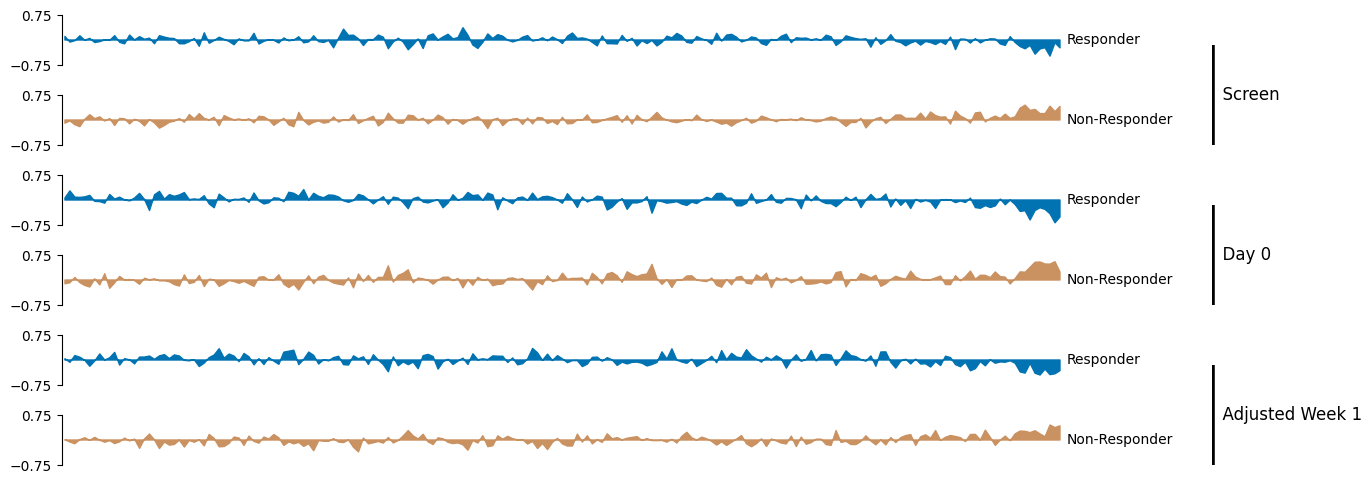

In [15]:
import marsilea as ma
import marsilea.plotter as mp
tracks = df
palette = sns.color_palette("colorblind")
colors = {
    "Responder": palette[0],
    "Non-Responder": palette[5]
}

lims = {
    "Screen": 0.75,
    "Day 0": 0.75,
    "Adjusted Week 1": 0.75,
}

TRACK_HEIGHT = 0.5
TRACK_PAD = 0.3
canvas = ma.ZeroHeight(10, name="track")

for _, row in tracks.iterrows():
    cond, enz, track = row
    name = f"{cond}{enz}"
    color = colors[cond]
    canvas.add_bottom(
        mp.Area(
            track,
            color=color,
            add_outline=False,
            alpha=1,
            label=cond,
            label_loc="right",
        ),
        size=TRACK_HEIGHT,
        pad=TRACK_PAD,
        name=name,
    )


enz_canvas = ma.ZeroHeight(1, name="enz")
for enz in tracks["enz"].drop_duplicates():
    enz_canvas.add_bottom(
        mp.Title(f"‎ ‎ {enz}", align="left"),
        size=TRACK_HEIGHT * 2,
        pad=TRACK_PAD * 2,
        name=enz,
    )

comp = canvas + 1.5 + enz_canvas
comp.render()

for enz in tracks["enz"].drop_duplicates():
    ax = comp.get_ax("enz", enz)
    ax.axvline(x=0, color="k", lw=4)

# Modify the limits
for _, row in tracks.iterrows():
    name = f"{row['cond']}{row['enz']}"
    lim = lims[row["enz"]]
    ax = comp.get_ax("track", name)
    ax.set_ylim(-1*lim, lim)
    ax.set_yticks([-1*lim,lim])
    
comp.save('F2F.pdf')